![](../assets/images/construction.gif)

# Journey 4
## Part 1


### Transfer Learning 

This is simply where we train a network for one task and then use some or all of that learning in a different task.

In [1]:
from os import listdir
from os.path import isdir, isfile, join
import re
import numpy as np
from PIL import Image
import random


In [3]:
DATA_DIR = '../data/fruits-360-data/fruits-360'
TEST_DATA = DATA_DIR + '/Test'
TRAIN_DATA = DATA_DIR + '/Training'

In [8]:
#
# Create a one-hot encoding for the given list
#
def create_one_hot_encoding_dicts(list_to_encode):
    list_to_one_hot = dict()
    one_hot_to_item = dict()
    for i, l in enumerate(list_to_encode):
        oh = np.zeros((len(list_to_encode)))
        oh[i] = 1
        list_to_one_hot[l] = oh
        one_hot_to_item[np.array2string(oh)] = l
    return list_to_one_hot, one_hot_to_item

In [9]:
#
# Return a list of only the JPG files for a given dir
#
def list_files(data_dir):
    jpg_files = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and re.search('\.jpg$',f,flags=re.IGNORECASE)]
    return jpg_files

In [10]:
#
# Load a given list of fruits from the selected data set location
#
def load_data(fruits_to_get, 
              test_data_dir,
              train_data_dir
             ):
    
    one_hot_dict, item_dict = create_one_hot_encoding_dicts(fruits_to_get)
        
    test_data = []
    train_data = []
    
    for fruit in fruits_to_get:
        
        test_fruit_dir = test_data_dir + "/" + fruit
        train_fruit_dir = train_data_dir + "/" + fruit
        
        if isdir(test_fruit_dir) and isdir(train_fruit_dir):
            one_hot_val = one_hot_dict[fruit]
            
            print("loading [" + fruit + "]" + " one hot: " + str(one_hot_val))
            
            print('Test Data')
            for img_file in list_files(test_fruit_dir):
                test_data.append([np.array(Image.open(join(test_fruit_dir,img_file))), one_hot_val])
                print('.', end='')
            print('')

            print('Training Data')
            for img_file in list_files(train_fruit_dir):
                train_data.append([np.array(Image.open(join(train_fruit_dir,img_file))), one_hot_val])
                print('.', end='')
            print('')

            img_shape = test_data[0][0].shape
            one_hot_shape = test_data[0][1].shape
            
            # Convert data to numpy
            x_test = np.zeros((len(test_data), *img_shape))
            y_test = np.zeros((len(test_data), one_hot_shape[0]))
            x_train = np.zeros((len(train_data), *img_shape))
            y_train = np.zeros((len(train_data), one_hot_shape[0]))
            
            i = 0 
            rnd_idx = random.sample(range(0, len(test_data)), len(test_data))
            for img, one_hot in test_data:
                x_test[rnd_idx[i]] = img / 255.0  # rescale 0.0 to 1.0
                y_test[rnd_idx[i]] = one_hot
                i += 1

            i = 0 
            rnd_idx = random.sample(range(0, len(train_data)), len(train_data))
            for img, one_hot in train_data:
                x_train[rnd_idx[i]] = img / 255.0  # rescale 0.0 to 1.0
                y_train[rnd_idx[i]] = one_hot
                i += 1

        else:
            raise Exception("Cannot load unknown fruit - missing from test and/or train data set[" + fruit + "]")
            
    return x_train, \
           y_train, \
           x_test, \
           y_test, \
           one_hot_dict, \
           item_dict
        

In [11]:
list_to_get = ["Apple Golden 1",
               "Apple Golden 2",
               "Apple Golden 3",
               "Apple Red 1",
               "Apple Red 2",
               "Apple Red 3"]              
x_train, y_train, x_test, y_test, _, item_dict = load_data(list_to_get, TEST_DATA, TRAIN_DATA)

loading [Apple Golden 1] one hot: [1. 0. 0. 0. 0. 0.]
Test Data
....................................................................................................................................................................
Training Data
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
loading [Apple Golden 2] one hot: [0. 1. 0. 0. 0. 0.]
Test Data
....................................................................................................................................................................
Training Data
.....................

In [12]:
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)
        

(961, 100, 100, 3)
(961, 6)
(2878, 100, 100, 3)
(2878, 6)


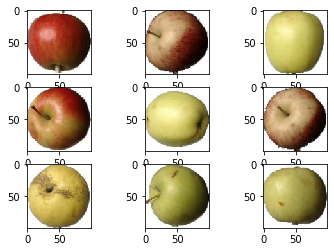

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline  

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i], interpolation='none')

In [15]:
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.datasets import mnist
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical

In [16]:
input_shape = (100, 100, 3)
num_classes = 6
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [17]:
    # Compile Model
    model.compile(loss=categorical_crossentropy,
                  optimizer=SGD(lr=0.01),
                  metrics=['accuracy'])

In [19]:
    batch_size = 32
    model.fit(x_train, y_train,
              epochs=50,
              batch_size=batch_size,
              shuffle=True,
              validation_data=(x_test, y_test)
              )

Train on 2878 samples, validate on 961 samples
Epoch 1/50
2878/2878 [==============================] - 44s 15ms/step - loss: 1.2864 - acc: 0.4871 - val_loss: 0.9356 - val_acc: 0.6181
Epoch 2/50
2878/2878 [==============================] - 43s 15ms/step - loss: 0.6853 - acc: 0.7446 - val_loss: 0.6100 - val_acc: 0.7565
Epoch 3/50
2878/2878 [==============================] - 42s 15ms/step - loss: 0.3443 - acc: 0.8871 - val_loss: 0.4272 - val_acc: 0.7763
Epoch 4/50
2878/2878 [==============================] - 42s 15ms/step - loss: 0.2054 - acc: 0.9451 - val_loss: 0.5354 - val_acc: 0.7950
Epoch 5/50
2878/2878 [==============================] - 42s 15ms/step - loss: 0.1168 - acc: 0.9746 - val_loss: 0.3617 - val_acc: 0.8273
Epoch 6/50
2878/2878 [==============================] - 42s 15ms/step - loss: 0.0210 - acc: 1.0000 - val_loss: 0.2937 - val_acc: 0.8762
Epoch 7/50
2878/2878 [==============================] - 42s 15ms/step - loss: 0.0093 - acc: 1.0000 - val_loss: 0.2833 - val_acc: 0.8835
E